In [30]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
test = pd.read_csv('/home/leandro/Documentos/Organizacion de datos/Fiuba-Big-Data-Analytics-TPs/Tp 2/Datos/Test_TP2_Datos_2020-2C.csv')

train = pd.read_csv('/home/leandro/Documentos/Organizacion de datos/Fiuba-Big-Data-Analytics-TPs/Tp 2/Datos/Train_TP2_Datos_2020-2C.csv')

In [3]:

def normaliza_df(df, ones_hots):
    # inicialmente voy con el tratamiento mas simple sobre los datos faltantes
    df = df.fillna(0)
    df = df.dropna()
    '''
      removemos la columna de la cual el modelo podria aprender que su existencia
      implica el Closed_won (ya que es un valor que se obtiene a posteriori de haber
      ganado y estaria mal usarlo ya que los modelos entrenadas con ella serian 
      incapaces de poder predecir correctamente)
    '''
    df = df.drop(['Sales_Contract_No'], axis=1)
    
    # irrelevantes
    df = df.drop(['Opportunity_Name'], axis=1)

    # dato cte = NaT
    df = df.drop(['Last_Activity'], axis=1)

    # basado en lo charlado con el grupo, ahora subdividimos el df de forma de tener
    # en cuenta los casos cerrados y cobertimos las varaibles categorias en su
    # representacion mas simple (siendo dos casos en Cloased_Won = 1 y Closed:_lost = 0)
    if 'Stage' in df.columns:
        df = df[((df['Stage'] == 'Closed Won') | (df['Stage'] == 'Closed Lost'))]
        df['Stage'] = df['Stage'].apply(lambda x: 1 if x == 'Closed Won' else 0)
    
    # hacemos que las variables temporales en las que nos vanos a enfocar sean del tipo correcto
    df['Account_Created_Date'] = pd.to_datetime(df['Account_Created_Date'], format="%m/%d/%Y")
    df['Opportunity_Created_Date'] = pd.to_datetime(df['Opportunity_Created_Date'], format="%m/%d/%Y")

    df['Quote_Type'] = df['Quote_Type'].apply(lambda x: 1 if x == 'Binding' else 0)
    
    # todo: convertir estas en una ventana de tiempo
    df = df.drop(['Planned_Delivery_Start_Date'], axis=1)
    df = df.drop(['Planned_Delivery_End_Date'], axis=1)

    categoric_cols = df.columns[df.dtypes==object].tolist() 
    numeric_cols = df.columns[df.dtypes=='float64'].tolist() 
    numeric_cols_2 = df.columns[df.dtypes=='int64'].tolist() 
    date_cols = df.columns[df.dtypes=='datetime64[ns]'].tolist() 
    
    print(categoric_cols)
    print('--------------')
    
    
    def crearOneHotDF(c1):
        if 'Stage' in df.columns:
            onehotencoder = OneHotEncoder(handle_unknown = 'ignore')
            onehotencoder.fit(df[[c1]])
            ones_hots[c1] = onehotencoder
        else:
            onehotencoder = ones_hots[c1]
        
        M = pd.DataFrame(onehotencoder.transform(df[[c1]]).toarray())
            
        num_cols = len(list(M))
        rng = range(0, num_cols)
        new_cols = [c1 + str(i) for i in rng] 
        M.columns = new_cols[:num_cols]
        return M

    categorical = pd.concat([crearOneHotDF(i) for i in categoric_cols], axis=1)

    df = pd.concat([categorical, df[numeric_cols], df[numeric_cols_2], df[date_cols]], axis=1)
    
    df = df.sort_values(by="Opportunity_Created_Date")
    
    df = df.drop(columns = 'Opportunity_Created_Date')
    df = df.drop(columns = 'Account_Created_Date')

    df = df.fillna(0)
    df = df.dropna()
    
    return df

In [4]:
one_hots = {}
train_encodiado = normaliza_df(train,one_hots)
test_encodiado = normaliza_df(test,one_hots)

['Region', 'Territory', 'Bureaucratic_Code', 'Source ', 'Billing_Country', 'Account_Name', 'Account_Owner', 'Opportunity_Owner', 'Account_Type', 'Opportunity_Type', 'Delivery_Terms', 'Brand', 'Product_Type', 'Size', 'Product_Category_B', 'Price', 'Currency', 'Quote_Expiry_Date', 'Last_Modified_Date', 'Last_Modified_By', 'Product_Family', 'Product_Name', 'ASP_Currency', 'ASP_(converted)_Currency', 'Month', 'Delivery_Quarter', 'Actual_Delivery_Date', 'Total_Amount_Currency', 'Total_Taxable_Amount_Currency', 'Prod_Category_A']
--------------
['Region', 'Territory', 'Bureaucratic_Code', 'Source ', 'Billing_Country', 'Account_Name', 'Account_Owner', 'Opportunity_Owner', 'Account_Type', 'Opportunity_Type', 'Delivery_Terms', 'Brand', 'Product_Type', 'Size', 'Product_Category_B', 'Price', 'Currency', 'Quote_Expiry_Date', 'Last_Modified_Date', 'Last_Modified_By', 'Product_Family', 'Product_Name', 'ASP_Currency', 'ASP_(converted)_Currency', 'Month', 'Delivery_Quarter', 'Actual_Delivery_Date', 'T

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_encodiado.drop(columns = 'Stage'),train_encodiado['Stage'],test_size=0.3)

In [6]:
#Logistic Regression

lr = LogisticRegression(solver='liblinear',multi_class='ovr')
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.583874139626352

In [34]:
#Linear SVC
Lsvc = LinearSVC(C=1, max_iter = 1000)
Lsvc.fit(X_train, y_train)
Lsvc.score(X_test, y_test)


/home/leandro/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.6635201573254671

In [15]:
#MultinomialNB
MNB = MultinomialNB()
MNB.fit(X_train, y_train)
MNB.score(X_test, y_test)

0.6483775811209439

In [16]:
#Random Forest

rf = RandomForestClassifier(n_estimators=40)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.8503441494591937

In [17]:
def get_score(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

In [19]:
X = train_encodiado.drop(columns = 'Stage')
y = train_encodiado['Stage']

models = [lr,Lsvc, MNB, rf]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X, y, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/home/leandro/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/leandro/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/leandro/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/leandro/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/leandro/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed t

In [20]:
entries

[('LogisticRegression', 0, 0.4920353982300885),
 ('LogisticRegression', 1, 0.6047197640117994),
 ('LogisticRegression', 2, 0.604308055473591),
 ('LogisticRegression', 3, 0.5812924166420773),
 ('LogisticRegression', 4, 0.5951608143995278),
 ('LinearSVC', 0, 0.5693215339233039),
 ('LinearSVC', 1, 0.48112094395280236),
 ('LinearSVC', 2, 0.4821481262909413),
 ('LinearSVC', 3, 0.5452935969312481),
 ('LinearSVC', 4, 0.6594865742106816),
 ('MultinomialNB', 0, 0.5690265486725664),
 ('MultinomialNB', 1, 0.7156342182890856),
 ('MultinomialNB', 2, 0.7058129241664207),
 ('MultinomialNB', 3, 0.6656830923576276),
 ('MultinomialNB', 4, 0.6323399232812039),
 ('RandomForestClassifier', 0, 0.6769911504424779),
 ('RandomForestClassifier', 1, 0.7106194690265487),
 ('RandomForestClassifier', 2, 0.6783712009442313),
 ('RandomForestClassifier', 3, 0.7005016228976099),
 ('RandomForestClassifier', 4, 0.6760106226025376)]

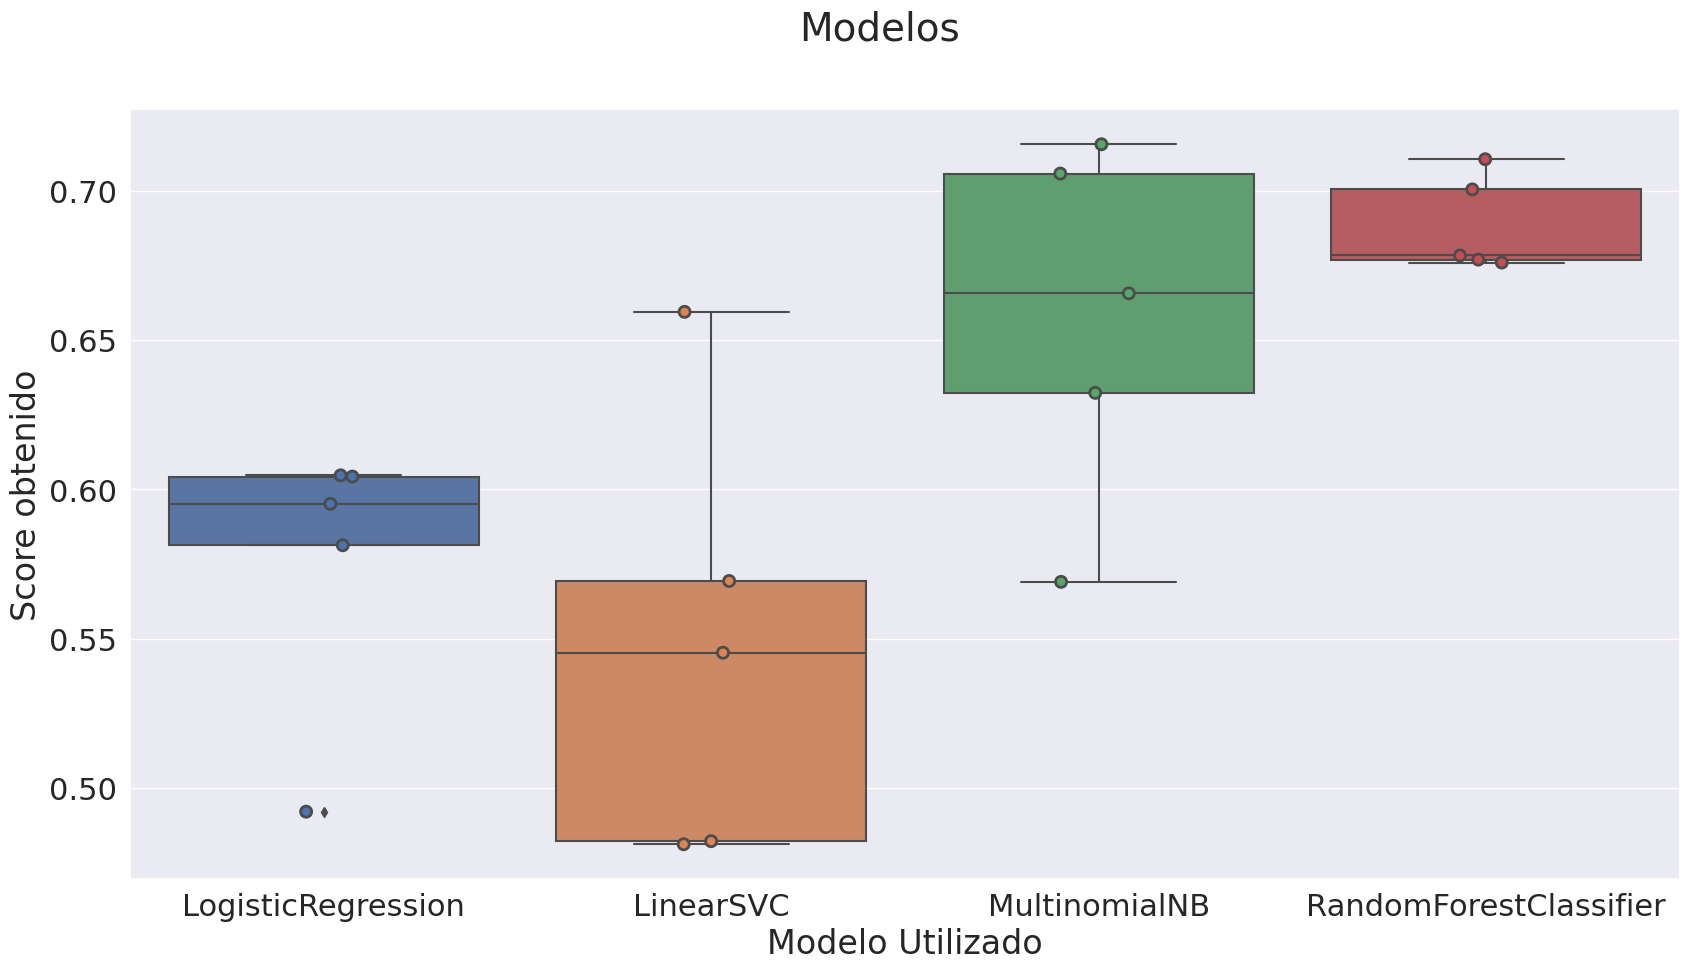

In [32]:
plt.style.use('default') 
plt.rcParams['figure.figsize'] = (20, 10)
fig = plt.figure()
sns.set(style="whitegrid") 
sns.set(font_scale = 2)

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,
size=8, jitter=True, edgecolor="gray", linewidth=2)
fig.suptitle('Modelos', fontsize=28)
plt.xlabel('Modelo Utilizado', fontsize=24)
plt.ylabel('Score obtenido', fontsize=24)
plt.show()